In [1]:
from datasets import load_dataset, VerificationMode
from collections import defaultdict
from teren.typing import *
import plotly.express as px

SEQ_LEN = 32
INFERENCE_TOKENS = 12_800
INFERENCE_BATCH_SIZE = INFERENCE_TOKENS // SEQ_LEN
print(f"{INFERENCE_BATCH_SIZE=}")
# TODO
N_PROMPTS = INFERENCE_BATCH_SIZE * 5

dataset = load_dataset(
    "apollo-research/Skylion007-openwebtext-tokenizer-gpt2",
    data_files="data/train-00000-of-00073.parquet",
    verification_mode=VerificationMode.NO_CHECKS,
    split="train",
)
dataset.set_format(type="torch")
input_ids = dataset["input_ids"].view(-1, SEQ_LEN)[:N_PROMPTS]

INFERENCE_BATCH_SIZE=400


In [2]:
from transformer_lens import HookedTransformer
import torch
from teren import utils as teren_utils
from teren.typing import *
from tqdm.auto import trange, tqdm


device = teren_utils.get_device_str()
print(f"{device=}")
torch.set_grad_enabled(False)
model = HookedTransformer.from_pretrained("gpt2-small", device=device)

device='cuda'
Loaded pretrained model gpt2-small into HookedTransformer


In [3]:
d_model = model.cfg.d_model
d_vocab = model.cfg.d_vocab
all_resid_acts = torch.empty(N_PROMPTS, SEQ_LEN, d_model)
LAYER = 9
hook_point = f"blocks.{LAYER}.hook_resid_pre"
for i in trange(0, N_PROMPTS, INFERENCE_BATCH_SIZE):
    # no need to move to device, as long as model is on a correct device
    batch_input_ids = input_ids[i : i + INFERENCE_BATCH_SIZE]
    _, cache = model.run_with_cache(
        batch_input_ids,
        names_filter=hook_point,
    )
    batch_resid_acts = cache[hook_point]
    all_resid_acts[i : i + INFERENCE_BATCH_SIZE] = batch_resid_acts

  0%|          | 0/5 [00:00<?, ?it/s]

In [4]:
import math

LOG2 = math.log(2)


def comp_js_divergence(p_logit, q_logit):
    p_logprob = torch.log_softmax(p_logit, dim=-1)
    q_logrprob = torch.log_softmax(q_logit, dim=-1)
    p = p_logprob.exp()
    q = q_logrprob.exp()

    m = 0.5 * (p + q)
    m_logprob = m.log()

    p_kl_div = (p * (p_logprob - m_logprob)).sum(-1)
    q_kl_div = (q * (q_logrprob - m_logprob)).sum(-1)

    assert p_kl_div.isfinite().all()
    assert q_kl_div.isfinite().all()
    return (p_kl_div + q_kl_div) / 2 * LOG2


# def comp_js_distance(p_logit, q_logit):
#     div = comp_js_divergence(p_logit, q_logit)
#     dist = torch.sqrt(div / LOG2)
#     # -1e-8 div gives NaN distance
#     dist[torch.isnan(dist) & (torch.abs(div) < 1e-6)] = 0
#     return dist


comp_js_divergence(
    torch.tensor([[5.0] + [0] * 10, [5.0] + [0] * 10]),
    torch.tensor([[5.0] + [0] * 10, [0] * 10 + [5.0]]),
)

tensor([9.6767e-09, 4.2689e-01])

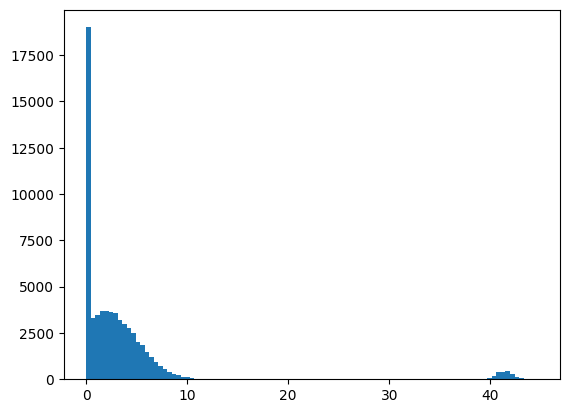

In [5]:
from fancy_einsum import einsum
import matplotlib.pyplot as plt
import matplotlib


def compute_dir_acts(direction):
    dot_prod = einsum("batch seq model, model -> batch seq", all_resid_acts, direction)
    return torch.relu(dot_prod)


def test_compute_dir_acts():
    direction = torch.randn(d_model)
    direction = direction / direction.norm()
    acts = compute_dir_acts(direction)
    assert acts.shape == (N_PROMPTS, SEQ_LEN)
    assert (acts >= 0).all()
    plt.hist(acts.flatten(), bins=100)
    plt.show()


test_compute_dir_acts()

In [6]:
def compute_abl_dir_acts_and_range(dir):
    dir_acts = compute_dir_acts(dir)
    dir_vecs = einsum("batch seq, model -> batch seq model", dir_acts, dir)
    abl_dir_acts = all_resid_acts - dir_vecs
    act_min, act_max = (
        dir_acts.min(),
        dir_acts.min() + (dir_acts.max() - dir_acts.min()) / 10,
    )
    return abl_dir_acts, (act_min, act_max)


def compute_pert_resid_acts(dir, num_bins):
    abl_dir_acts, (act_min, act_max) = compute_abl_dir_acts_and_range(dir)
    act_values = torch.linspace(act_min, act_max, num_bins)
    pert = einsum("act, model -> act model", act_values, dir)
    # shape: (act, batch, seq, model)
    return abl_dir_acts + pert.view(num_bins, 1, 1, d_model)

In [32]:
def compute_jsd_data(dir, num_bins):
    pert_resid_acts = compute_pert_resid_acts(dir, num_bins)
    batch_size = 100
    ret = defaultdict(list)
    for batch_i in trange(batch_size):
        logits = model(
            pert_resid_acts[:, batch_i],
            start_at_layer=LAYER,
        )
        for i in range(num_bins):
            for j in range(i + 1, num_bins):
                jsd = comp_js_divergence(logits[i], logits[j])
                ret[(i, j)].append(jsd.cpu())
    return {k: torch.stack(v) for k, v in ret.items()}


def compute_jsd_mean_matrix(jsd_data, num_bins):
    ret = torch.zeros(num_bins, num_bins)
    for (i, j), jsd in jsd_data.items():
        ret[i, j] = ret[j, i] = jsd.mean().cpu()
    return ret

In [8]:
from teren.saes import SAE_ID_BY_LAYER_BY_FAMILY
from sae_lens import SAE

sae_family = "gpt2-small-res-jb"
sae_id = SAE_ID_BY_LAYER_BY_FAMILY[sae_family][LAYER]
sae, _, log_sparsities = SAE.from_pretrained(
    release=sae_family, sae_id=sae_id, device=device
)
u, s, vh = torch.linalg.svd(all_resid_acts.view(-1, d_model), full_matrices=False)

In [38]:
import numpy as np


def plot_jsd_matrix(jsd_matrix):
    assert jsd_matrix.shape[0] == jsd_matrix.shape[1]
    nbins = jsd_matrix.shape[0]
    fig = plt.figure(figsize=(12, 8))  # Increased figure height
    gs = fig.add_gridspec(2, 2, height_ratios=[2, 1])  # 2 rows, 2 columns

    ax1 = fig.add_subplot(gs[0, 0])  # First row, first column
    ax2 = fig.add_subplot(gs[0, 1])  # First row, second column
    ax3 = fig.add_subplot(gs[1, :])  # Second row, span both columns

    # First subplot (heatmap)
    margin = 50 / nbins
    im = ax1.imshow(
        jsd_matrix.T,
        cmap="Reds",
        extent=(-margin, 100 + margin, 100 + margin, 0 - margin),
    )
    fig.colorbar(im, ax=ax1, label="JSD(A || B)")
    ax1.set_title("pairwise heatmap")
    ax1.set_xlabel("act % B")
    ax1.set_ylabel("act % A")
    tick_positions = np.linspace(0, 100, nbins)
    tick_labels = [f"{v:<3}" for v in np.round(tick_positions).astype(int)]
    ax1.set_xticks(tick_positions, tick_labels, font="monospace", rotation=-90)
    ax1.set_yticks(tick_positions, tick_labels, font="monospace")

    # Second subplot (line plot)
    norm = matplotlib.colors.Normalize(vmin=0, vmax=100)
    cmap = plt.get_cmap("gist_rainbow")
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    for row, label, color in zip(jsd_matrix, tick_labels, cmap(norm(tick_positions))):
        ax2.plot(tick_positions, row, label=label, color=color)
    ax2.set_title("lines for each act % A")
    ax2.set_xlabel("act % B")
    ax2.set_ylabel("JSD(A || B)")
    ax2.set_xlim(-margin, 100 + margin)
    ax2.set_xticks(tick_positions, tick_labels, font="monospace", rotation=-90)

    # Add colorbar for line colors
    cbar = fig.colorbar(sm, ax=ax2)
    cbar.set_label("act % A")

    # Third subplot (full-width line plot)
    for row, label, color in zip(jsd_matrix, tick_labels, cmap(norm(tick_positions))):
        ax3.plot(tick_positions, row, label=label, color=color)
    ax3.set_title("lines for each act % A, bottom 1% of JSD values")
    ax3.set_xlabel("act % B")
    ax3.set_ylabel("JSD(A || B)")
    ax3.set_xlim(-margin, 100 + margin)
    min_, max_ = jsd_matrix.min().item(), jsd_matrix.max().item()
    ax3.set_ylim(min_, min_ + (max_ - min_) * 0.01)
    ax3.set_xticks(tick_positions, tick_labels, font="monospace", rotation=-90)

    plt.tight_layout()
    plt.show()


# def plot_random_dir_jsd_matrix(seed, nbins):
#     print(f"random, seed={seed}")
#     torch.manual_seed(seed)
#     dir = torch.randn(d_model)
#     dir = dir / dir.norm()
#     plot_jsd_matrix(dir, nbins)


# def plot_sae_dir_jsd_matrix(fid, nbins):
#     print(f"SAE, fid={fid}")
#     plot_jsd_matrix(sae.W_dec[fid].cpu(), nbins)


# def plot_svd_dir_jsd_matrix(idx, nbins):
#     print(f"SVD, idx={idx}")
#     plot_jsd_matrix(vh[:, idx], nbins)

# plot_random_dir_jsd_matrix(0, 6)
# plot_sae_dir_jsd_matrix(0, 21)
# plot_svd_dir_jsd_matrix(0, 21)

In [54]:
def get_single_jsd_matix(jsd_data, nbins, batch, seq):
    assert len(jsd_data) == (nbins * (nbins - 1)) / 2
    max_batch, max_seq = next(iter(jsd_data.values())).shape
    assert batch < max_batch
    assert seq < max_seq
    ret = torch.zeros(nbins, nbins)
    for (i, j), jsd in jsd_data.items():
        ret[i, j] = ret[j, i] = jsd[batch, seq].item()
    return ret


SAE i=9000


  0%|          | 0/100 [00:00<?, ?it/s]

.
batch=87, seq=1

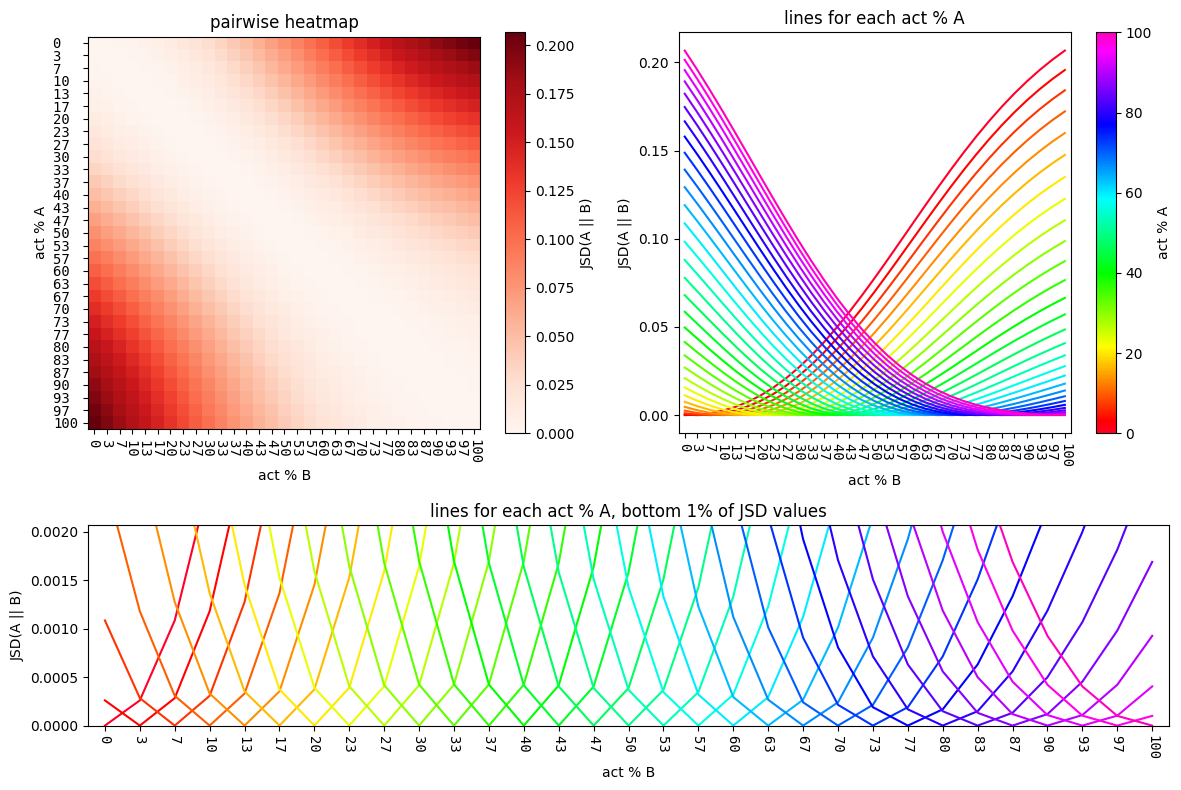

In [55]:
nbins = 31
# for i in range(0, sae.cfg.d_sae, 3_000):
for i in [9000]:
    print(f"\nSAE {i=}")
    sae_dir = sae.W_dec[i].cpu()
    sae_jsd_data = compute_jsd_data(sae_dir, num_bins=nbins)
    # for batch in range(100):
    #     for seq in range(32):
    batch, seq = 87, 1
    print(".", end="")
    jsd_matrix_sae = get_single_jsd_matix(sae_jsd_data, nbins, batch=batch, seq=seq)
    # if jsd_matrix_sae.max() < 0.2:
    #     continue
    print(f"\n{batch=}, {seq=}", end="")
    plot_jsd_matrix(jsd_matrix_sae)